In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import shap
from sklearn import datasets
from sklearn.metrics import roc_auc_score
import numbers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, r2_score
import seaborn as sns
from TreeModelsFromScratch.DecisionTree import DecisionTree
from TreeModelsFromScratch.RandomForest import RandomForest
from TreeModelsFromScratch.SmoothShap import verify_shap_model, smooth_shap, GridSearchCV_scratch, cross_val_score_scratch
from TreeModelsFromScratch.datasets import DATASETS_CLASSIFICATION, DATASETS_REGRESSION, DATASET_PATH
from imodels.util.data_util import get_clean_dataset
import os
from datetime import datetime
import pickle
from tqdm import tqdm

# Smooth SHAP

## Titanic

In [55]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","HS_performance","classification")
filename = "20221206_titanic_results_smSHAP"

In [56]:
# Load pickle results
with open(f'{data_path}/{filename}.pickle', 'rb') as handle:
    smSHAP_titanic_result = pickle.load(handle)

In [67]:
smSHAP_titanic_result.get("results_scratch_hsRF_smSHAP").get("grid_cv_results")[3]

{'best_param_comb': (0.1,),
 'best_test_score': 0.7733441144480545,
 'best_test_scores': array([0.67832168, 0.803125  , 0.72934697, 0.79871692, 0.8676236 ,
        0.75119237, 0.75695733, 0.86336032, 0.73015873, 0.75463822]),
 'mean_test_scores': array([0.77334411, 0.76242372, 0.76519398, 0.76662266, 0.76894374,
        0.76734963, 0.76843225]),
 'param_combinations': [(0.1,), (1,), (5,), (10,), (20,), (50,), (100,)],
 'cv_scores_p_split': array([[0.67832168, 0.803125  , 0.72934697, 0.79871692, 0.8676236 ,
         0.75119237, 0.75695733, 0.86336032, 0.73015873, 0.75463822],
        [0.77972028, 0.81655844, 0.72272727, 0.7252322 , 0.73524721,
         0.75952381, 0.77491694, 0.73478261, 0.71652174, 0.85900673],
        [0.7587234 , 0.78518519, 0.75555556, 0.7252322 , 0.81370968,
         0.77782258, 0.78070175, 0.72991453, 0.80218855, 0.7229064 ],
        [0.73760818, 0.73571429, 0.76593234, 0.7866016 , 0.81978654,
         0.77113821, 0.77560976, 0.81904762, 0.79233871, 0.66244939],
 

In [57]:
# Store absolute smSHAP coefs
smSHAP_coefs_titanic = np.abs([i.get("smSHAP_coefs") for i in smSHAP_titanic_result.get("results_scratch_hsRF_smSHAP").get("grid_cv_results")])
smSHAP_coefs_pen_lambda_titanic = np.abs([i.get("smSHAP_coefs") for i in smSHAP_titanic_result.get("results_scratch_hsRF_smSHAP_test").get("grid_cv_results")])

In [58]:
feat_names = ['Age', 'Pclass', 'Sex (Female)', 'PassengerId']

# Create dfs dor plotting
smSHAP_coefs_df_titanic = pd.DataFrame(smSHAP_coefs_titanic, columns=feat_names)
smSHAP_coefs_df_titanic["experiment"]="smSHAP"
smSHAP_coefs_pen_lambda_df_titanic = pd.DataFrame(smSHAP_coefs_pen_lambda_titanic, columns=feat_names)
smSHAP_coefs_pen_lambda_df_titanic["experiment"]="smSHAP penalized lambda"

#Combine dataframes
smSHAP_df_titanic = pd.concat([smSHAP_coefs_df_titanic, smSHAP_coefs_pen_lambda_df_titanic])
smSHAP_df_long_titanic = pd.melt(smSHAP_df_titanic, "experiment", var_name="feature")

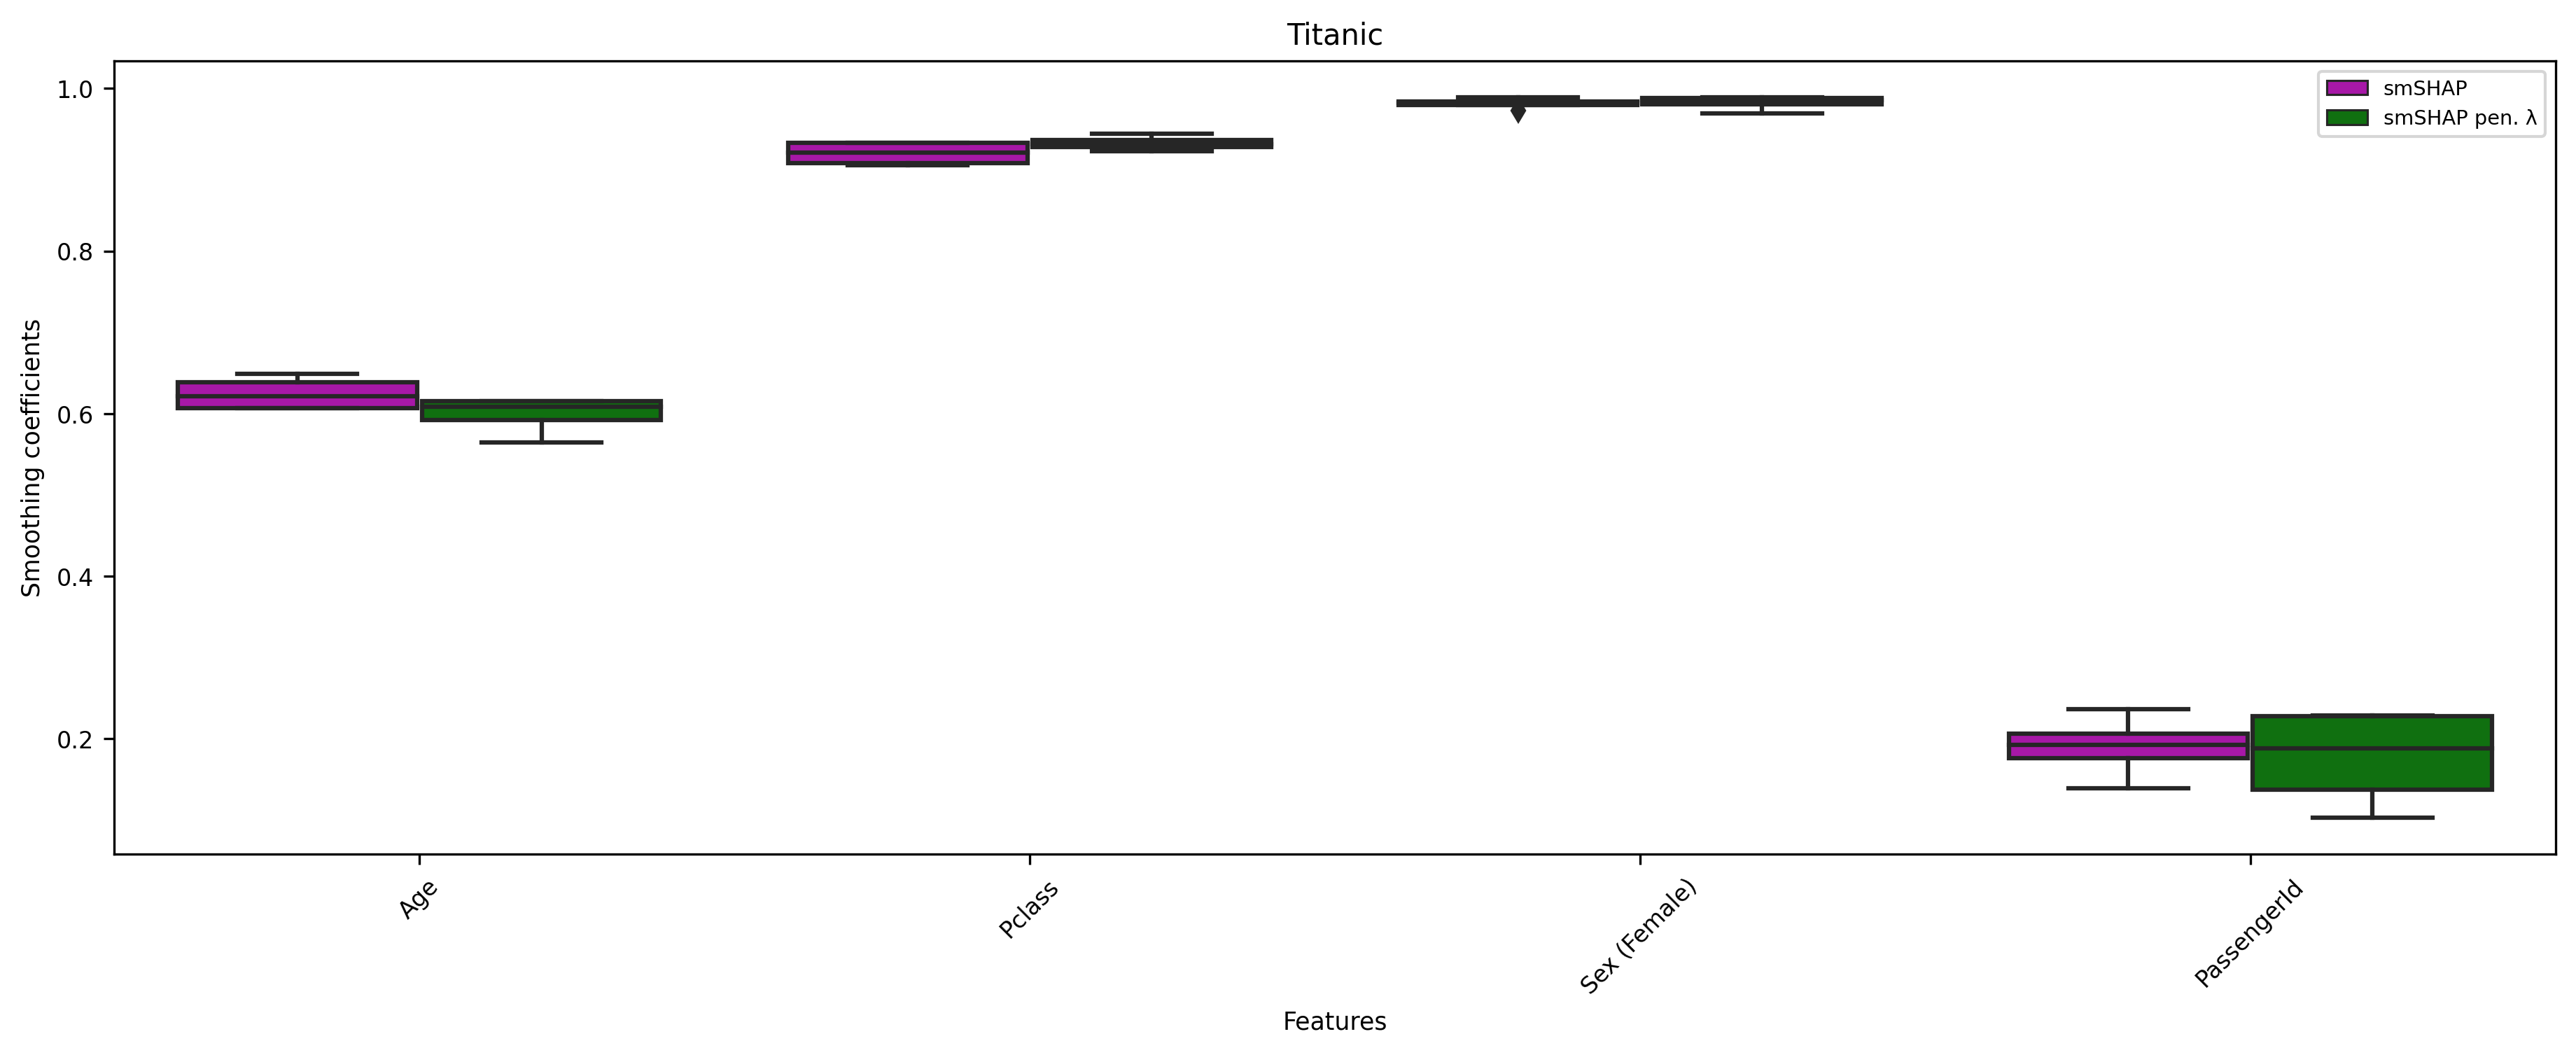

In [59]:
# Draw a nested boxplot to show abs shap values per feature and experiment
fig = plt.figure(figsize=(15,5))

ax = sns.boxplot(x="feature", y="value", hue="experiment", palette=["m", "g"],
            data=smSHAP_df_long_titanic)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
ax.set_title(f"Titanic", fontsize="medium")
ax.set_xlabel("Features", fontsize="small")
ax.set_ylabel("Smoothing coefficients", fontsize="small")
h, l = ax.get_legend_handles_labels()
ax.legend(handles=h, labels=["smSHAP", "smSHAP pen. λ"], fontsize="x-small")
for label in (ax.get_xticklabels() + ax.get_yticklabels()): label.set_fontsize(8);


In [60]:
#save figure 
filename = f"{data_path}/{filename}_smSHAP_coef_plot.png"
fig.savefig(filename)

## Strobl

### Functions to generate strobl data

In [6]:
def simulate_data_strobl(n=120, # number of rows in data
                         M=100, # number of simulations
                         relevance = 0.15, # signal srength (0 for NULL)
                         seed=None):
  
    if isinstance(seed, numbers.Integral) or (seed is None):
        random_state = np.random.RandomState(seed)
    elif isinstance(seed, np.random.RandomState):
        random_state = seed

    x1 = random_state.standard_normal(size=(n,M))
    x2 = random_state.randint(1, 3, size=(n,M))
    x3 = random_state.randint(1, 5, size=(n,M))
    x4 = random_state.randint(1, 11, size=(n,M))
    x5 = random_state.randint(1, 21, size=(n,M))
    X = np.array([x1,x2,x3,x4,x5]).T
      
    y = random_state.binomial(n = 1, p = (0.5 + np.array([-1,1])[x2-1]* relevance))

    return X, y

In [12]:
def run_strobl_simulation(n=120, M=1, relevance_power=0.15, cv=10, random_seed=None):
    
    random_state = np.random.RandomState(random_seed)

    #Null simulation
    X_null, y_null = simulate_data_strobl(n=n, M=M, relevance=0, seed=random_state)

    #Power simulation
    X_power, y_power = simulate_data_strobl(n=n, M=M, relevance=relevance_power, seed=random_state)

    i = 0
    grid = {"HS_lambda":[0.1,1,5,10,25,50,100]}

    # ---- NULL --------

    # # Null RF: 
    # null_rf = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=False)
    # null_rf.fit(X_null[i,:,:], y_null[:,i])

    # # Null hsRF: 
    # null_rfHS = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=False, HShrinkage=True)
    # grid_cv_HS = GridSearchCV_scratch(null_rfHS, grid, X_null[i,:,:], y_null[:,i], cv=cv, scoring_func=roc_auc_score, random_state=random_state)

    # Null hsRF smooth SHAP: 
    null_rfHSsmSH = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob_SHAP=True, HS_smSHAP=True)
    grid_cv_HSsmSH = GridSearchCV_scratch(null_rfHSsmSH, grid, X_null[i,:,:], y_null[:,i], cv=cv, scoring_func=roc_auc_score, random_state=random_state)

    # Null hsRF smooth SHAP penalized lambda 
    null_rfHSsmSH_penlam = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob_SHAP=True, HS_smSHAP=True, testHS=True)
    grid_cv_HSsmSH_penlam = GridSearchCV_scratch(null_rfHSsmSH_penlam, grid, X_null[i,:,:], y_null[:,i], cv=cv, scoring_func=roc_auc_score, random_state=random_state)

    # Null hsRF nodewise MSE: 
    null_rfHSmse = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=True, HS_nodewise_shrink_type="MSE_ratio")
    grid_cv_HSmse = GridSearchCV_scratch(null_rfHSmse, grid, X_null[i,:,:], y_null[:,i], cv=cv, scoring_func=roc_auc_score, random_state=random_state)

    # Null hsRF nodewise MSE wit penalized lambda: 
    null_rfHSmse_penlam = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=True, HS_nodewise_shrink_type="MSE_ratio", testHS=True)
    grid_cv_HSmse_penlam = GridSearchCV_scratch(null_rfHSmse_penlam, grid, X_null[i,:,:], y_null[:,i], cv=cv, scoring_func=roc_auc_score, random_state=random_state)

    # ---- POWER --------

    # # Power: 
    # power_rf = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=False)
    # power_rf.fit(X_power[i,:,:], y_power[:,i])

    # # Power hsRF: 
    # power_rfHS = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=False, HShrinkage=True)
    # grid_cv_HS_p = GridSearchCV_scratch(power_rfHS, grid, X_power[i,:,:], y_power[:,i], cv=cv, scoring_func=roc_auc_score, random_state=random_state)

    # Power hsRF smooth SHAP: 
    power_rfHSsmSH = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob_SHAP=True, HS_smSHAP=True)
    grid_cv_HSsmSH_p = GridSearchCV_scratch(power_rfHSsmSH, grid, X_power[i,:,:], y_power[:,i], cv=cv, scoring_func=roc_auc_score, random_state=random_state)

    # Power hsRF smooth SHAP penalized lambda: 
    power_rfHSsmSH_penlam = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob_SHAP=True, HS_smSHAP=True, testHS=True)
    grid_cv_HSsmSH_penlam_p = GridSearchCV_scratch(power_rfHSsmSH_penlam, grid, X_power[i,:,:], y_power[:,i], cv=cv, scoring_func=roc_auc_score, random_state=random_state)

    # Power hsRF nodewise MSE: 
    power_rfHSmse = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=True, HS_nodewise_shrink_type="MSE_ratio")
    grid_cv_HSmse_p = GridSearchCV_scratch(power_rfHSmse, grid, X_power[i,:,:], y_power[:,i], cv=cv, scoring_func=roc_auc_score, random_state=random_state)

    # Power hsRF nodewise MSE: 
    power_rfHSmse_penlam = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob=True, HS_nodewise_shrink_type="MSE_ratio", testHS=True)
    grid_cv_HSmse_penlam_p = GridSearchCV_scratch(power_rfHSmse_penlam, grid, X_power[i,:,:], y_power[:,i], cv=cv, scoring_func=roc_auc_score, random_state=random_state)

    results = {
        "simulation_params":
            {"n": n, 
            "M": M, 
            "relevance_power": relevance_power, 
            "cv": cv,
            "random_seed": random_seed},
        "data":{ 
                "X_null": X_null,
                "y_null": y_null,
                "X_power": X_power,
                "y_power": y_power},
        "Null":
            {
            # "rf":{
            #     "model": null_rf,
            # "HSrf":{
            #     "model": null_rfHS,
            #     "grid_cv": grid_cv_HS},
            "HSrfsmSH":{
                "model": null_rfHSsmSH,
                "grid_cv": grid_cv_HSsmSH},
            "HSrfsmSH_pen_lambda":{
                "model": null_rfHSsmSH_penlam,
                "grid_cv": grid_cv_HSsmSH_penlam},
            "HSrfmse":{
                "model": null_rfHSmse,
                "grid_cv": grid_cv_HSmse},
            "HSrfmse_pen_lambda":{
                "model": null_rfHSmse_penlam,
                "grid_cv": grid_cv_HSmse_penlam},
            },
        "Power":
            {
            # "rf":{
            #     "model": power_rf,
            # "HSrf":{
            #     "model": power_rfHS,
            #     "grid_cv": grid_cv_HS_p},
            "HSrfsmSH":{
                "model": power_rfHSsmSH,
                "grid_cv": grid_cv_HSsmSH_p},
            "HSrfsmSH_pen_lambda":{
                "model": power_rfHSsmSH_penlam,
                "grid_cv": grid_cv_HSsmSH_penlam_p},
            "HSrfmse":{
                "model": power_rfHSmse,
                "grid_cv": grid_cv_HSmse_p},
            "HSrfmse_pen_lambda":{
                "model": power_rfHSmse_penlam,
                "grid_cv": grid_cv_HSmse_penlam_p},
            }}
    
    return results


### Run simulation

In [13]:
#strobl_results = run_strobl_simulation(n=120, M=1, relevance_power=0.15, cv=10)

In [14]:
#Store results as pickle
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","strobl_simulation")
today_str = datetime.today().strftime("%Y%m%d")

with open(f'{data_path}/dist_smoothing_coefs_strobl_{today_str}.pickle', 'wb') as handle:
    pickle.dump(strobl_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Prepare data for plotting

In [15]:
#Load models
HSrfsmSH_null = strobl_results.get("Null").get("HSrfsmSH").get("model")
HSrfMSE_null = strobl_results.get("Null").get("HSrfmse").get("model")
HSrfsmSH_penlam_null = strobl_results.get("Null").get("HSrfsmSH_pen_lambda").get("model")
HSrfMSEpenlam_null = strobl_results.get("Null").get("HSrfmse_pen_lambda").get("model")

HSrfsmSH_power = strobl_results.get("Power").get("HSrfsmSH").get("model")
HSrfMSE_power = strobl_results.get("Power").get("HSrfmse").get("model")
HSrfsmSH_penlam_power = strobl_results.get("Power").get("HSrfsmSH_pen_lambda").get("model")
HSrfMSEpenlam_power = strobl_results.get("Power").get("HSrfmse_pen_lambda").get("model")

In [54]:
models = [HSrfsmSH_null, HSrfsmSH_penlam_null, HSrfsmSH_power, HSrfsmSH_penlam_power]
for model in models:
    print(model.HS_lambda)

100
1
1
25


In [16]:
# Store absolute smSHAP coefs
null_smSHAP_coefs = np.abs(HSrfsmSH_null.smSHAP_coefs)
null_smSHAP_coefs_pen_lambda = np.abs(HSrfsmSH_penlam_null.smSHAP_coefs)
power_smSHAP_coefs = np.abs(HSrfsmSH_power.smSHAP_coefs)
power_smSHAP_coefs_pen_lambda = np.abs(HSrfsmSH_penlam_power.smSHAP_coefs)

#store as list 
null_coefs = [null_smSHAP_coefs, null_smSHAP_coefs_pen_lambda]
power_coefs = [power_smSHAP_coefs, power_smSHAP_coefs_pen_lambda]

In [33]:
feat_names = ["x1","x2","x3","x4","x5"]

null_dfs = []

for i, arr in enumerate(null_coefs):
    df = pd.DataFrame(arr.reshape(1,len(arr)), columns=feat_names)
    if i ==0:
        df["experiment"]="smSHAP"
    else:
        df["experiment"]="smSHAP penalized lambda"
    null_dfs.append(df)

In [34]:
power_dfs = []

for i, arr in enumerate(power_coefs):
    df = pd.DataFrame(arr.reshape(1,len(arr)), columns=feat_names)
    if i ==0:
        df["experiment"]="smSHAP"
    else:
        df["experiment"]="smSHAP penalized lambda"
    power_dfs.append(df)

In [35]:
#Combine dataframes
null_strobl_df = pd.concat(null_dfs)
null_strobl_df_long = pd.melt(null_strobl_df, "experiment", var_name="feature")

#power
power_strobl_df = pd.concat(power_dfs)
power_strobl_df_long = pd.melt(power_strobl_df, "experiment", var_name="feature")

### Plot distributions

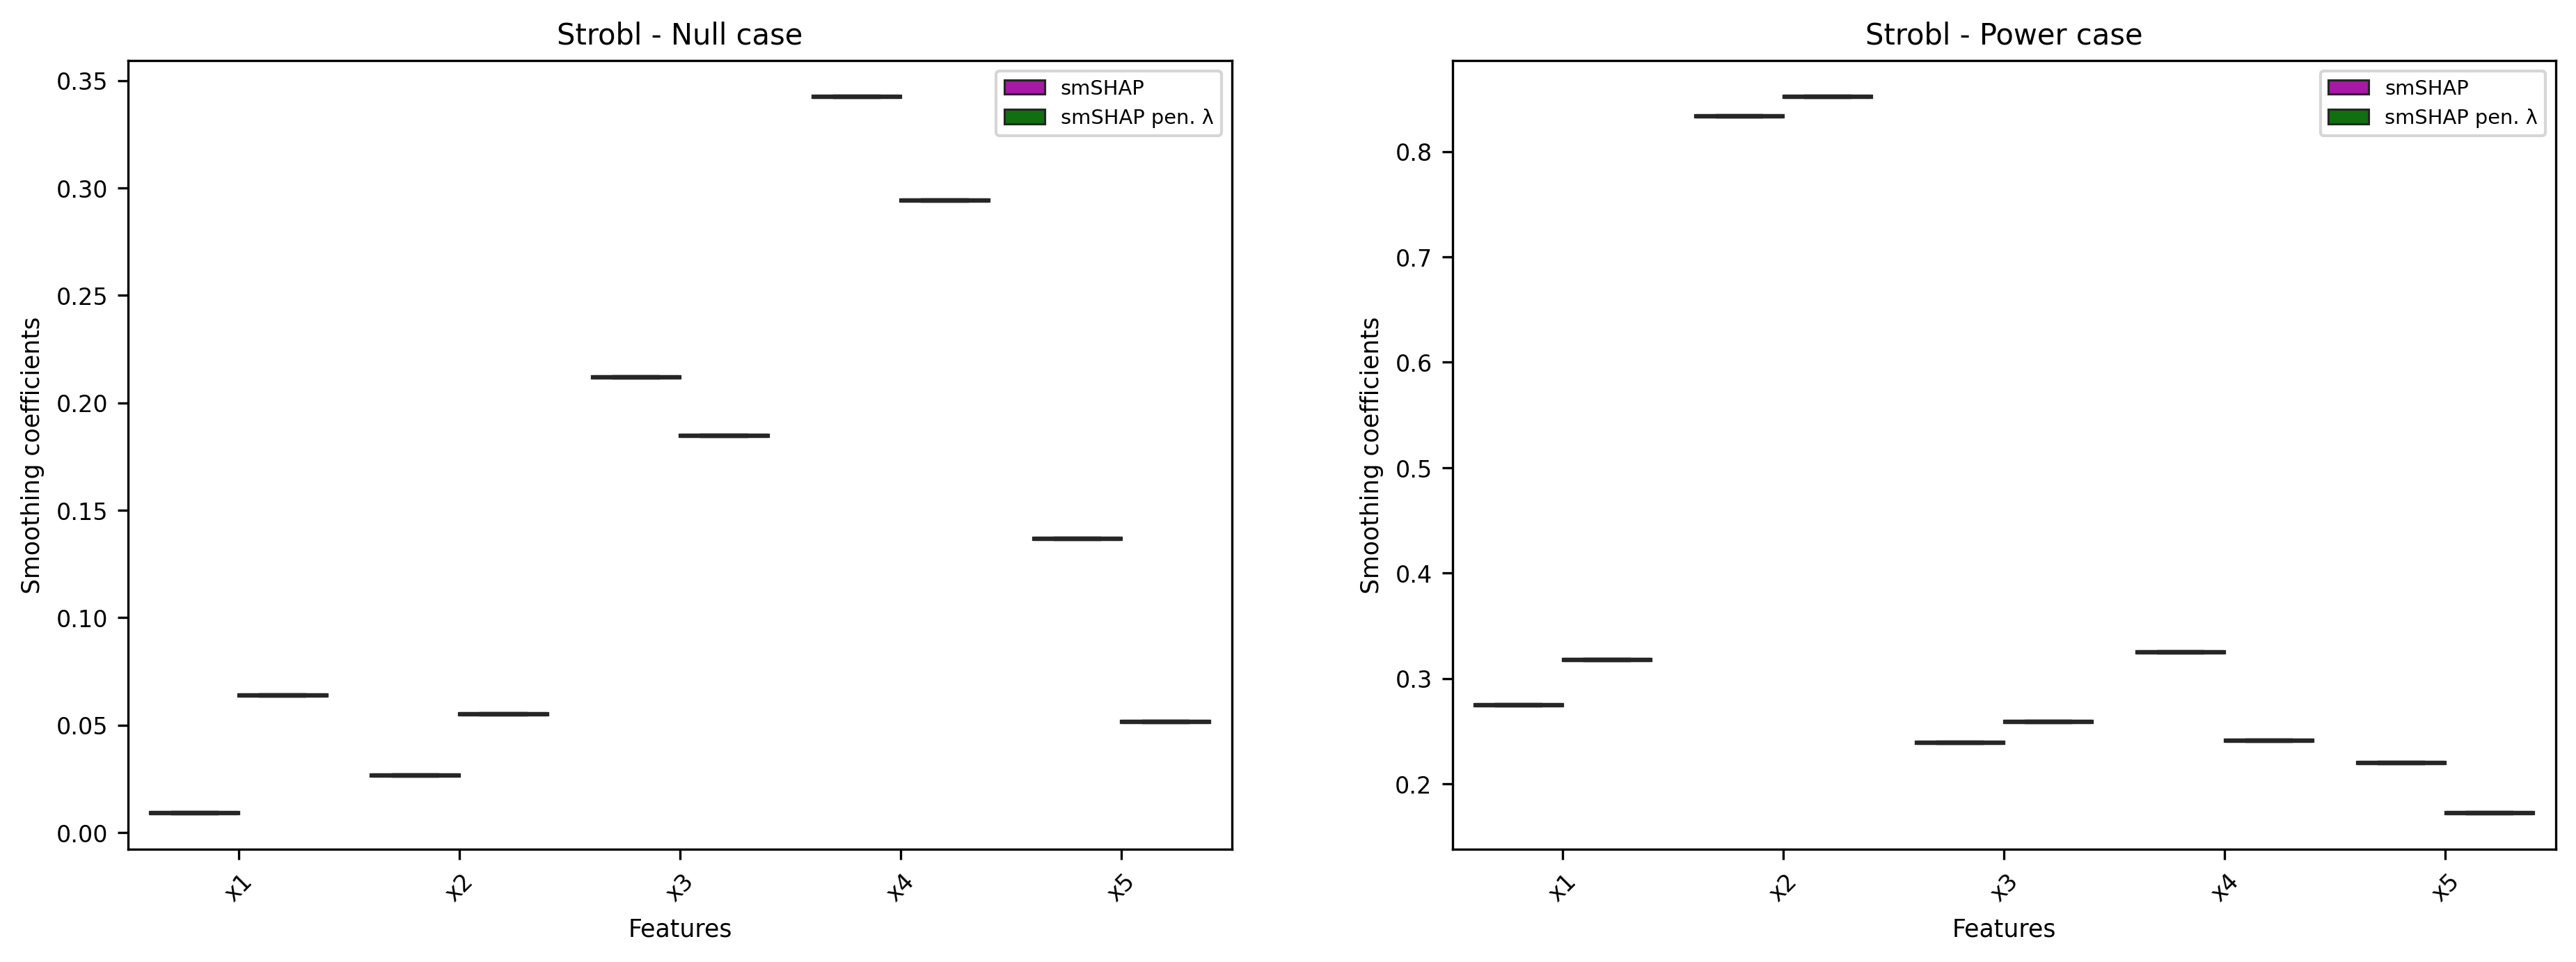

In [36]:
# Draw a nested boxplot to show abs shap values per feature and experiment
fig, axs = plt.subplots(1,2,figsize=(15,5))

n = sns.boxplot(x="feature", y="value", hue="experiment", palette=["m", "g"],
            data=null_strobl_df_long, ax=axs[0])
p = sns.boxplot(x="feature", y="value", hue="experiment", palette=["m", "g"],
            data=power_strobl_df_long, ax=axs[1])

for i, ax in enumerate(fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
    if i==0:
        ax.set_title(f"Strobl - Null case", fontsize="medium")
    else:
        ax.set_title(f"Strobl - Power case", fontsize="medium")
    ax.set_xlabel("Features", fontsize="small")
    ax.set_ylabel("Smoothing coefficients", fontsize="small")
    h, l = ax.get_legend_handles_labels()
    ax.legend(handles=h, labels=["smSHAP", "smSHAP pen. λ"], fontsize="x-small")
    for label in (ax.get_xticklabels() + ax.get_yticklabels()): label.set_fontsize(8);


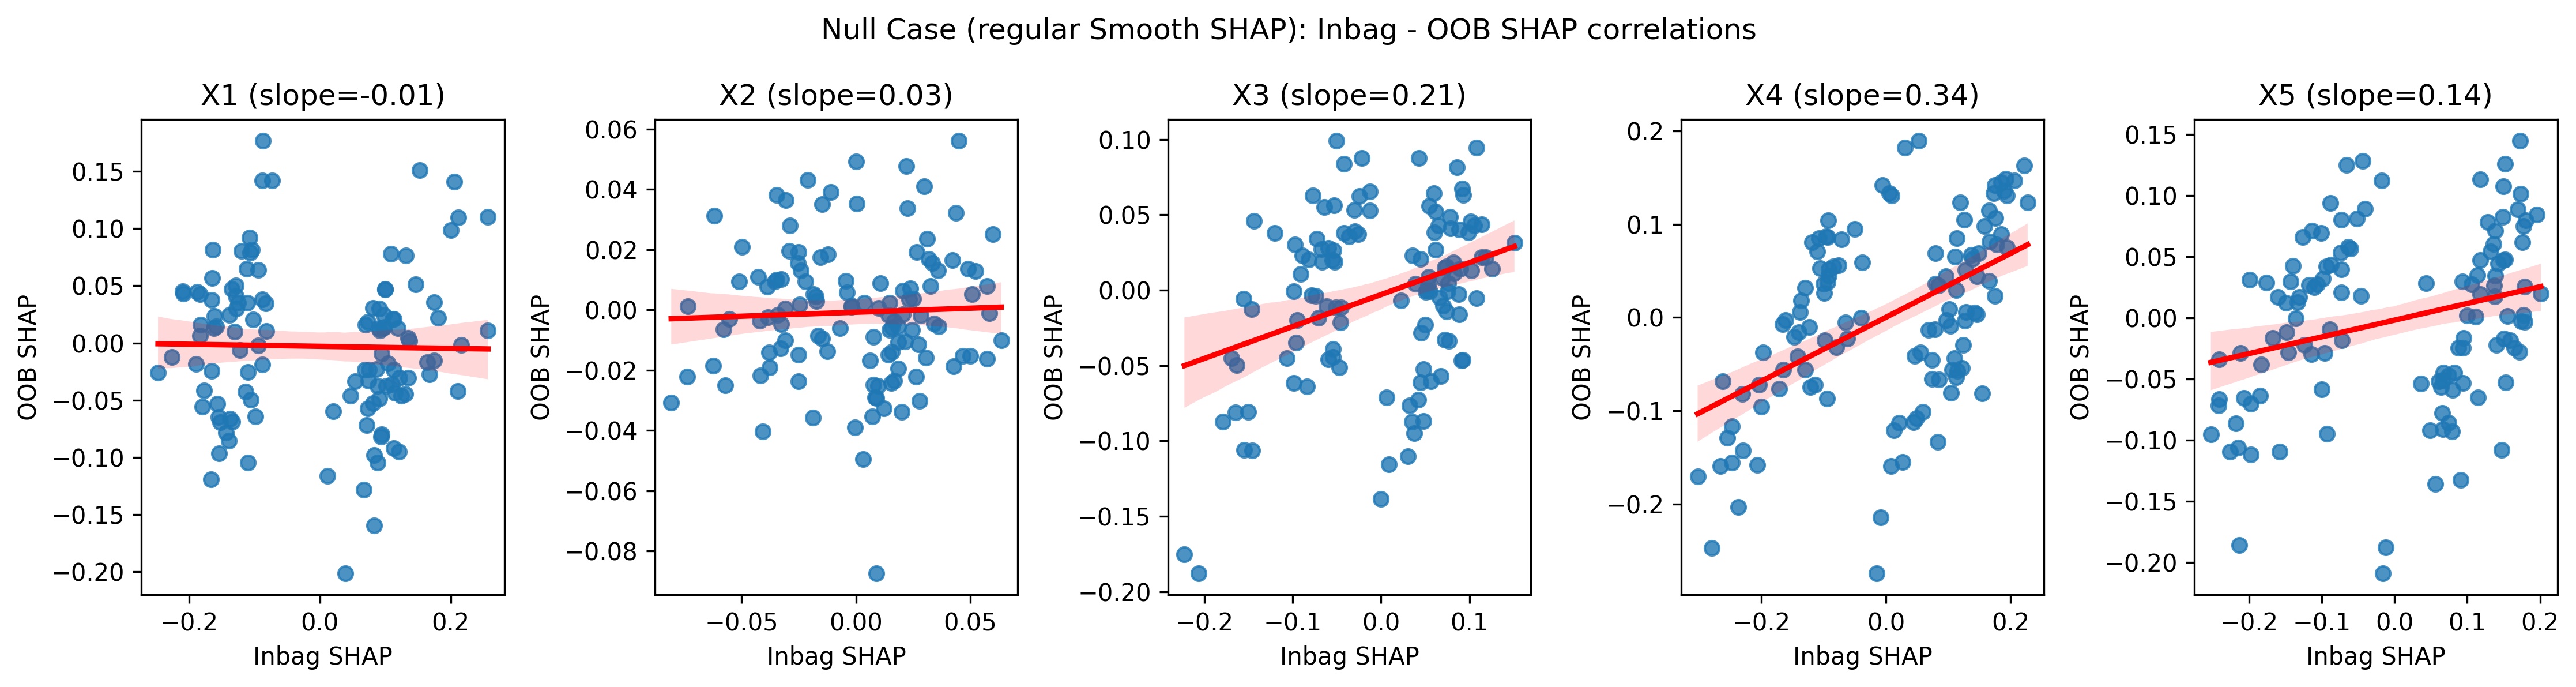

In [45]:
from scipy.stats import linregress
fig, axs = plt.subplots(1,5, figsize=(15,4))

for i in range(5):
    p = sns.regplot(x=HSrfsmSH_null.inbag_SHAP_values[:, i].reshape(-1, 1), y=HSrfsmSH_null.oob_SHAP_values[:, i], line_kws={"color": "red"}, ax=axs[i])
    slope, intercept, r_value, p_value, std_err = linregress(x=p.get_lines()[0].get_xdata(),y=p.get_lines()[0].get_ydata())
    axs[i].set_title(f"X{i+1} (slope={round(slope,2)})")# - regression coef: {np.round(rf_scr.smSHAP_coefs[i],2)}")
    axs[i].set_xlabel("Inbag SHAP")
    axs[i].set_ylabel("OOB SHAP")

#plt.setp(axs, xlim=[0, 0.5], ylim=[0, 0.5]);
fig.suptitle("Null Case (regular Smooth SHAP): Inbag - OOB SHAP correlations")
plt.tight_layout();

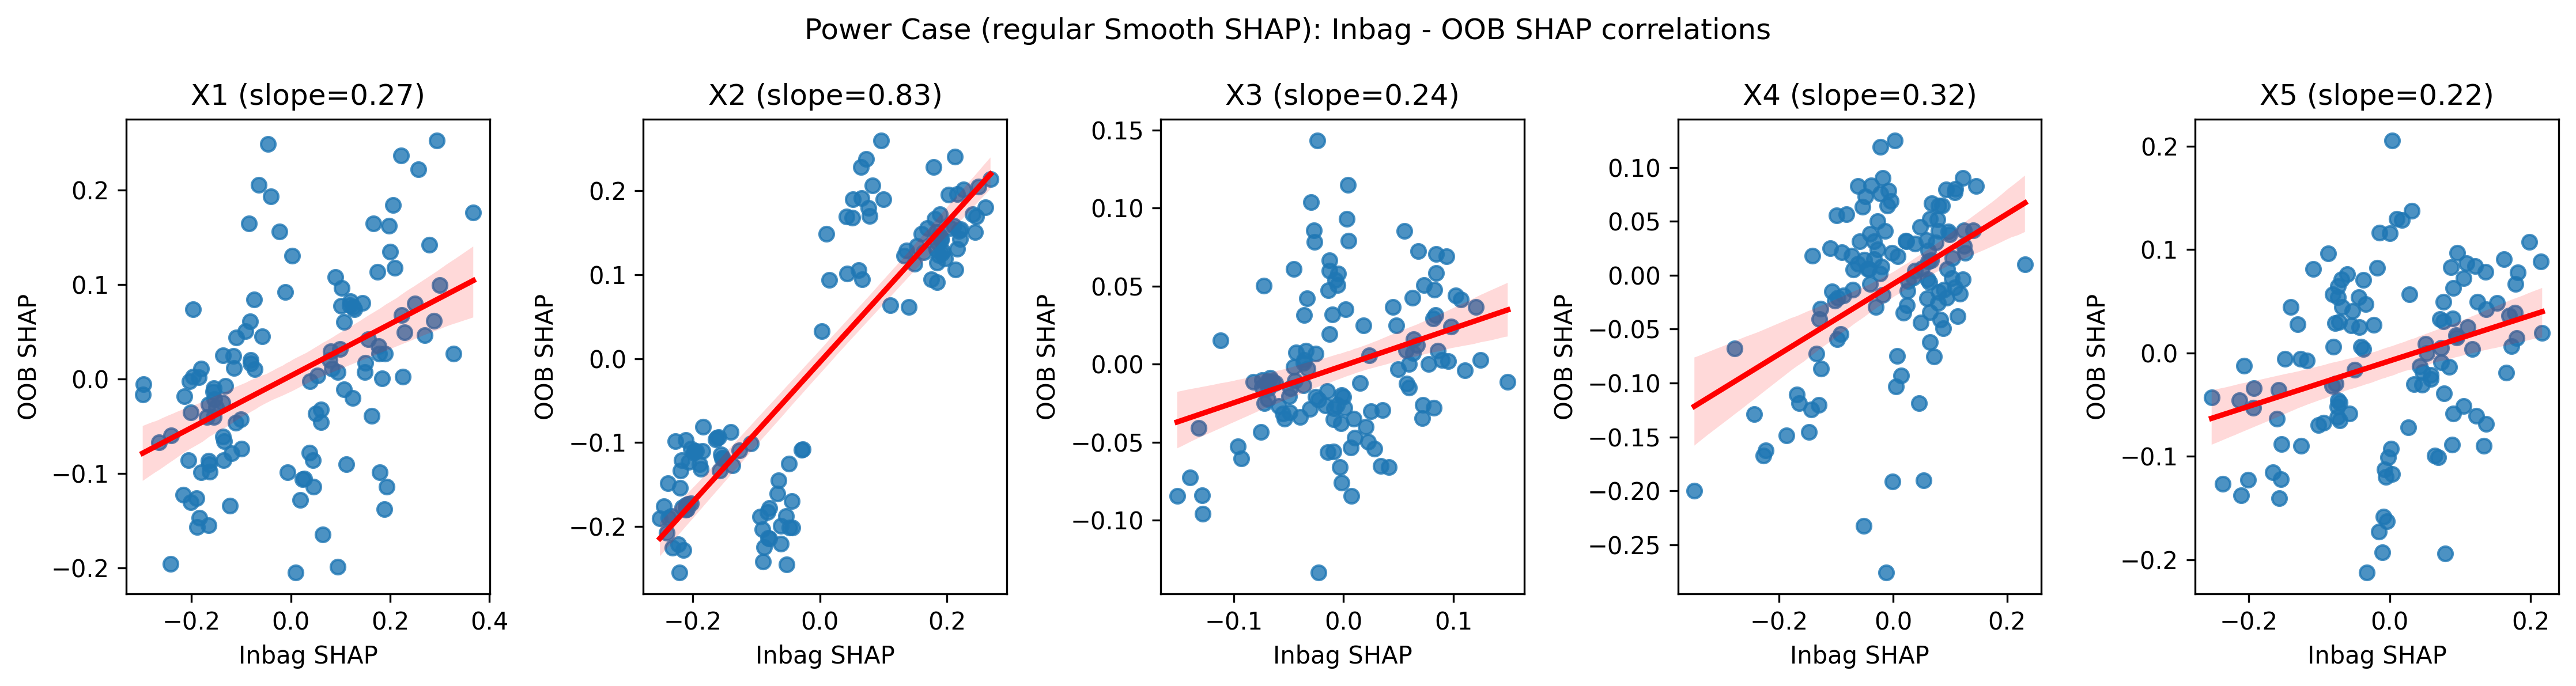

In [46]:
from scipy.stats import linregress
fig, axs = plt.subplots(1,5, figsize=(15,4))

for i in range(5):
    p = sns.regplot(x=HSrfsmSH_power.inbag_SHAP_values[:, i].reshape(-1, 1), y=HSrfsmSH_power.oob_SHAP_values[:, i], line_kws={"color": "red"}, ax=axs[i])
    slope, intercept, r_value, p_value, std_err = linregress(x=p.get_lines()[0].get_xdata(),y=p.get_lines()[0].get_ydata())
    axs[i].set_title(f"X{i+1} (slope={round(slope,2)})")# - regression coef: {np.round(rf_scr.smSHAP_coefs[i],2)}")
    axs[i].set_xlabel("Inbag SHAP")
    axs[i].set_ylabel("OOB SHAP")

#plt.setp(axs, xlim=[0, 0.5], ylim=[0, 0.5]);
fig.suptitle("Power Case (regular Smooth SHAP): Inbag - OOB SHAP correlations")
plt.tight_layout();

## Friedman1 (MARS)